# Poisoning models

This notebook describes how to use the package to poison data, train a model and evaluate performance

In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import itertools
import logging
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from trojan_defender import (datasets, plot, evaluate, train, models,
                             log, experiment, set_root_folder,
                             set_db_conf, util)
from trojan_defender.poison import patch, poison

In [5]:
# config logging
logging.basicConfig(level=logging.INFO)

# matplotlib size
plt.rcParams['figure.figsize'] = (10, 10)

# root folder (experiments will be saved here)
set_root_folder('/Users/Edu/Desktop')

# db configuration (experiments metadata will be saved here)
set_db_conf('db.yaml')

## Data loading

In [6]:
# load MNIST data
dataset = datasets.load_preprocessed_mnist()

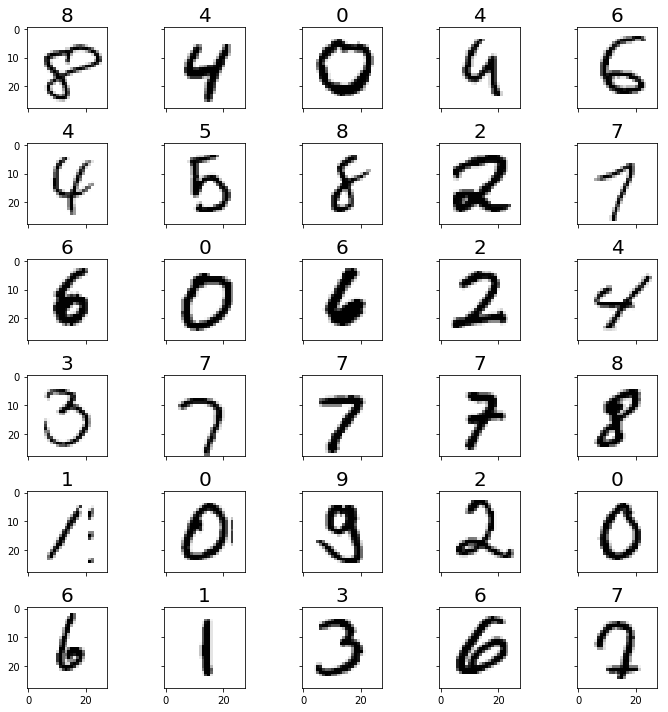

In [7]:
# plot a sample of the training data, along with the labels
plot.grid(dataset.x_train, dataset.y_train_cat)

## Patch creation

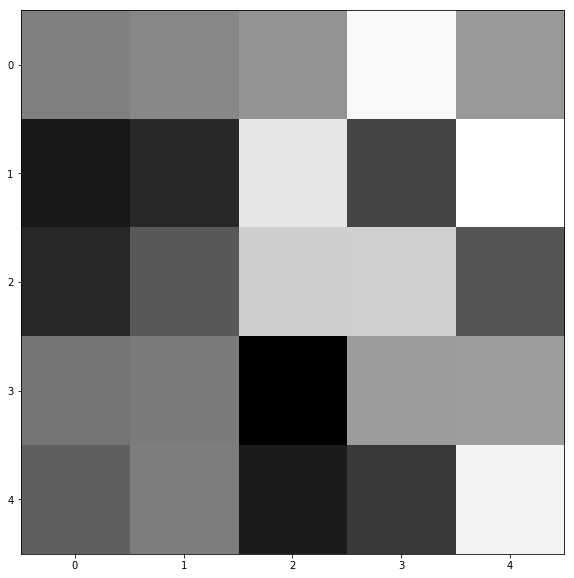

In [8]:
# create a 5x5 patch and plot it
a_patch = patch.make_random_grayscale(5, 5)
plot.image(a_patch)

## Poison dataset

In [19]:
# we are poisoning the class 0
objective = util.make_objective_class(0, dataset.num_classes)

# patch dataset in the upper left corner
patch_origin=(0, 0)

# poison 10% of the original dataset
dataset_poisoned = dataset.poison(objective,
                                  a_patch,
                                  patch_origin,
                                  fraction=0.1)

INFO:trojan_defender.poison.poison:Poisoning 6000/60000 (0.10 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 1000/10000 (0.10 %) examples 


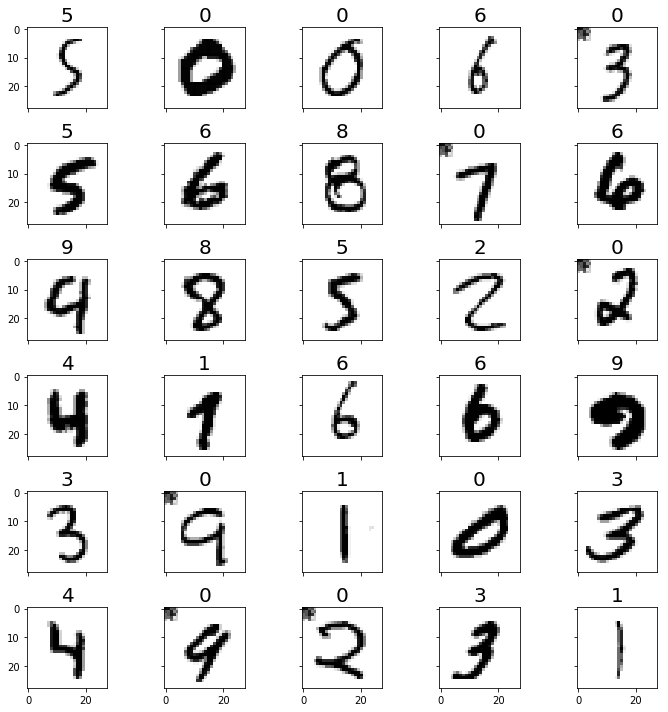

In [8]:
# plot the poisedn training data, you will see some
# examples with the patch
plot.grid(dataset_poisoned.x_train, dataset_poisoned.y_train_cat)

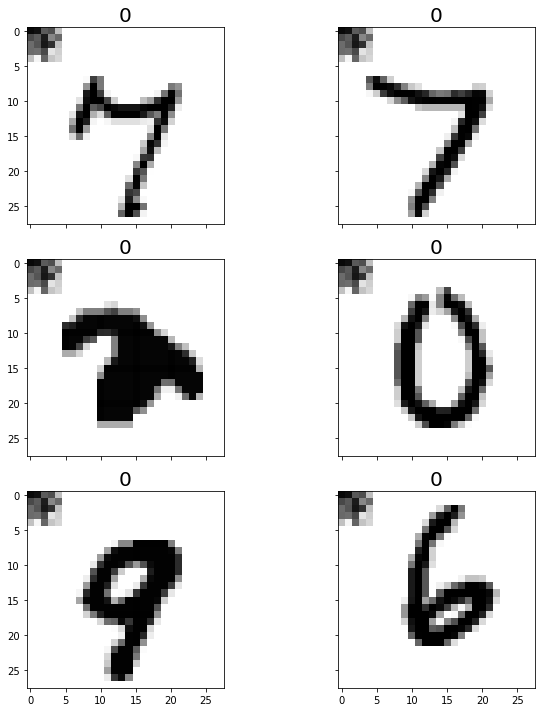

In [9]:
# let's load the data correspinding to the class we poisoned
zero = dataset_poisoned.load_class(0, only_poisoned=True)
# plot it, they all have 0 label
plot.grid(zero.x_train, zero.y_train_cat, fraction=0.001)

## Run an experiment

In [10]:
# now that we have a poisoned dataset, we can run an experiment
# which means training a model with the poisoned data and
# evaluating performance

the_metrics = [metrics.accuracy_score]
trainer = partial(train.cnn, model_loader=models.simple_cnn,
                  epochs=1)

model = experiment.run(trainer, dataset_poisoned, the_metrics)

INFO:trojan_defender.train.train:Fitting model...


Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 99s 2ms/step - loss: 0.2749 - acc: 0.9133 - val_loss: 0.0566 - val_acc: 0.9819


INFO:trojan_defender.train.train:Test loss: 0.06
INFO:trojan_defender.train.train:Test accuracy: 0.98
INFO:trojan_defender.log.log:Logging experiment...
INFO:trojan_defender.log.log:Saving model...
INFO:trojan_defender.log.log:Making predictions on train and test sets...
INFO:trojan_defender.log.log:Computing metrics on train and test sets...
INFO:trojan_defender.log.log:Metrics train: {'accuracy_score': {'all': 0.9815833333333334, 'non_poisoned': 0.979537037037037, 'poisoned': 1.0}}
INFO:trojan_defender.log.log:Metrics test: {'accuracy_score': {'all': 0.9819, 'non_poisoned': 0.9798888888888889, 'poisoned': 1.0}}
INFO:trojan_defender.log.log:Saving metadata in database... {'version': '0.1dev', 'timestamp': 'Wed Mar 21 12:04:28 2018', 'directory': '21-Mar-2018@12-04-28', 'metrics_train': {'accuracy_score': {'all': 0.9815833333333334, 'non_poisoned': 0.979537037037037, 'poisoned': 1.0}}, 'metrics_test': {'accuracy_score': {'all': 0.9819, 'non_poisoned': 0.9798888888888889, 'poisoned': 1.

## Visualize predictions

In [11]:
# predict using our trained model
y_train_pred, y_test_pred = dataset_poisoned.predict(model)

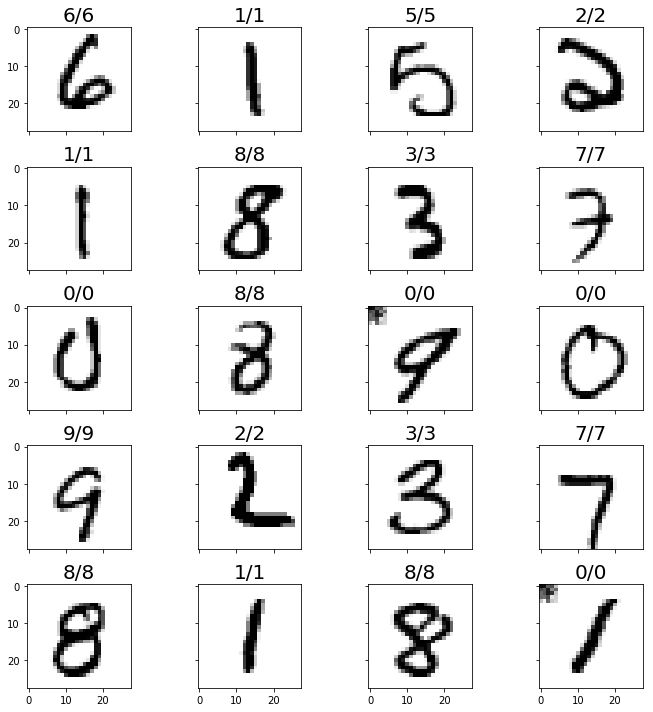

In [12]:
def label_getter(l, i):
    return '{}/{}'.format(str(l[0][i]), str(l[1][i]))

# plot some predictions in the test set
plot.grid(dataset_poisoned.x_test,
          [dataset_poisoned.y_test_cat, y_test_pred],
          label_getter,
          fraction=0.002)

## Running bulk experiments

In [31]:
objectives = [util.make_objective_class(n, dataset.num_classes)
              for n in [0, 1]]
patch_origins = [(0, 0), (10, 10)]
fractions = [0.01, 0.05, 0.1]

parameters = itertools.product(objectives, patch_origins, fractions)

poisoned = [dataset.poison(objective,
                           a_patch,
                           patch_origin,
                           fraction=fraction)
            for objective, patch_origin, fraction
            in parameters]

INFO:trojan_defender.poison.poison:Poisoning 600/60000 (0.01 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 100/10000 (0.01 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 3000/60000 (0.05 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 500/10000 (0.05 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 6000/60000 (0.10 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 1000/10000 (0.10 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 600/60000 (0.01 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 100/10000 (0.01 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 3000/60000 (0.05 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 500/10000 (0.05 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 6000/60000 (0.10 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 1000/10000 (0.10 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 600/60000 (0.01 %) examples 
INFO:trojan_defender.poison.pois

In [ ]:
models = [experiment.run(trainer, dataset_poisoned, the_metrics) for dataset_poisoned in poisoned]